迁移学习

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
plt.ion()

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(256),
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)
print(image_datasets['train'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 244, 'val': 153}
['ants', 'bees']
Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


torch.Size([3, 228, 906])
(228, 906, 3)


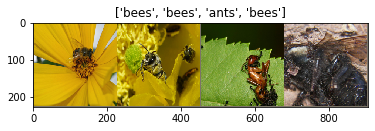

In [30]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # 标准差 * inp + 平均值
    inp = np.clip(inp, 0, 1)  # 将每个元素限制在 0 和 1 之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # scheduler: torch.optim.lr_scheduler
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)  # loss * batch_size
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

微调 convnet

In [21]:
# model_ft = models.resnet18(pretrained=True)
model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)  # 重新生成一个线性层, 输出为 2, 因为只有两个分类

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=1)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
# model_ft = train_model(model_ft, criterion, optimizer_ft, None, num_epochs=5)

 768/999
----------
train Loss: 0.3427 Acc: 0.8607
val Loss: 0.1695 Acc: 0.9281

Epoch 769/999
----------
train Loss: 0.2578 Acc: 0.8648
val Loss: 0.1865 Acc: 0.9346

Epoch 770/999
----------
train Loss: 0.3065 Acc: 0.8689
val Loss: 0.2089 Acc: 0.9216

Epoch 771/999
----------
train Loss: 0.2976 Acc: 0.8852
val Loss: 0.2275 Acc: 0.9150

Epoch 772/999
----------
train Loss: 0.3003 Acc: 0.8730
val Loss: 0.2266 Acc: 0.8954

Epoch 773/999
----------
train Loss: 0.3257 Acc: 0.8566
val Loss: 0.1895 Acc: 0.9150

Epoch 774/999
----------
train Loss: 0.2448 Acc: 0.8811
val Loss: 0.1891 Acc: 0.9281

Epoch 775/999
----------
train Loss: 0.2522 Acc: 0.8934
val Loss: 0.2034 Acc: 0.9085

Epoch 776/999
----------
train Loss: 0.3047 Acc: 0.8525
val Loss: 0.2317 Acc: 0.9020

Epoch 777/999
----------
train Loss: 0.2695 Acc: 0.8648
val Loss: 0.2241 Acc: 0.9085

Epoch 778/999
----------
train Loss: 0.2543 Acc: 0.8975
val Loss: 0.1906 Acc: 0.9216

Epoch 779/999
----------
train Loss: 0.1918 Acc: 0.9221
val

In [ ]:
import matplotlib as mpl
print(mpl.backends.backend)
# mpl.use('TkAgg')
mpl.use('module://ipykernel.pylab.backend_inline')

visualize_model(model_ft)

convnet 作为固定特征提取器

In [27]:
model_conv = models.resnet18(pretrained=True)
# 固定参数, 设置 requires_grad 为 False
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  # 重新生成一个线性层, 输出为 2, 因为只有两个分类

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
# model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)
model_conv = train_model(model_conv, criterion, optimizer_conv, None, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6250 Acc: 0.6352
val Loss: 0.3500 Acc: 0.8497

Epoch 1/29
----------
train Loss: 0.5498 Acc: 0.7295
val Loss: 0.2405 Acc: 0.9477

Epoch 2/29
----------
train Loss: 0.3600 Acc: 0.8648
val Loss: 0.2040 Acc: 0.9346

Epoch 3/29
----------
train Loss: 0.4228 Acc: 0.8115
val Loss: 0.2862 Acc: 0.8758

Epoch 4/29
----------
train Loss: 0.3804 Acc: 0.8402
val Loss: 0.1732 Acc: 0.9412

Epoch 5/29
----------
train Loss: 0.3775 Acc: 0.8320
val Loss: 0.1990 Acc: 0.9412

Epoch 6/29
----------
train Loss: 0.3711 Acc: 0.8484
val Loss: 0.1944 Acc: 0.9281

Epoch 7/29
----------
train Loss: 0.3420 Acc: 0.8320
val Loss: 0.1822 Acc: 0.9542

Epoch 8/29
----------
train Loss: 0.3910 Acc: 0.8279
val Loss: 0.1711 Acc: 0.9542

Epoch 9/29
----------
train Loss: 0.4307 Acc: 0.8115
val Loss: 0.1989 Acc: 0.9281

Epoch 10/29
----------
train Loss: 0.4327 Acc: 0.8033
val Loss: 0.2846 Acc: 0.8889

Epoch 11/29
----------
train Loss: 0.3305 Acc: 0.8443
val Loss: 0.1744 Acc: 0.9477

Ep

In [ ]:
visualize_model(model_conv)

In [ ]:
plt.ioff()
plt.show()